<a href="https://colab.research.google.com/github/PuiPu/data_sci_final_project/blob/main/GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# 使用個人訪問令牌克隆私有存儲庫
!git clone https://github.com/PuiPu/data_sci_final_project.git

fatal: destination path 'data_sci_final_project' already exists and is not an empty directory.


In [17]:
import pandas as pd

# Load the uploaded CSV file to check its structure
file_path = '/content/data_sci_final_project/aapl_us_d.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the data
data.head()


,Date,Open,High,Low,Close,Volume
0,1984-09-07,0.100763,0.101999,0.099546,0.100763,9.767604e+07
1,1984-09-10,0.100763,0.101071,0.098340,0.100165,7.581254e+07
2,1984-09-11,0.101071,0.103814,0.101071,0.101999,1.787705e+08
3,1984-09-12,0.101999,0.102597,0.098928,0.098928,1.561713e+08
4,1984-09-13,0.104432,0.104730,0.104432,0.104432,2.432310e+08


In [18]:
import numpy as np

# Convert Date to datetime format and set as index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Check for missing values
missing_values = data.isnull().sum()

# Use only the 'Close' column for this task
close_prices = data['Close']

# Display basic information about the data
missing_values, close_prices.describe()


(Open      0
 High      0
 Low       0
 Close     0
 Volume    0
 dtype: int64,
 count    10080.000000
 mean        24.228588
 std         48.513977
 min          0.054803
 25%          0.292288
 50%          0.883006
 75%         21.649000
 max        234.820000
 Name: Close, dtype: float64)

In [19]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices_scaled = scaler.fit_transform(close_prices.values.reshape(-1, 1))

# Define a function to create sequences for time series prediction
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length])
    return np.array(sequences), np.array(targets)

# Define sequence length
sequence_length = 60  # Use 60 days of data to predict the next day's price

# Create sequences
X, y = create_sequences(close_prices_scaled, sequence_length)

# Split into training and testing datasets
train_size = int(len(X) * 0.8)  # 80% training data
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Display the shapes of the datasets
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((8016, 60, 1), (2004, 60, 1), (8016, 1), (2004, 1))

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

# Define the GRU model
model = Sequential([
    GRU(50, return_sequences=True, input_shape=(sequence_length, 1)),  # First GRU layer
    Dropout(0.2),  # Dropout for regularization
    GRU(50),  # Second GRU layer
    Dropout(0.2),
    Dense(1)  # Output layer to predict the next price
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary
model.summary()

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                          │ (None, 60, 50)              │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,301 (91.02 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - loss: 1.3305e-04 - val_loss: 6.9504e-04
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 27s 107ms/step - loss: 1.5967e-05 - val_loss: 1.5677e-04
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 35s 82ms/step - loss: 1.4251e-05 - val_loss: 0.0016
Epoch 4/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - loss: 1.2151e-05 - val_loss: 1.5289e-04
Epoch 5/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - loss: 1.1840e-05 - val_loss: 1.4440e-04
Epoch 6/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 40s 78ms/step - loss: 1.2995e-05 - val_loss: 3.1716e-04
Epoch 7/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - loss: 1.1632e-05 - val_loss: 4.6945e-04
Epoch 8/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - loss: 1.4220e-05 - val_loss: 1.6161e-04
Epoch 9/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - loss: 1.3179e-05 - val_loss: 3.7033e-04
Epoch 10/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - loss: 1.2055e-05 - val_loss: 1.3903e-04
Epoch 11/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 2

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


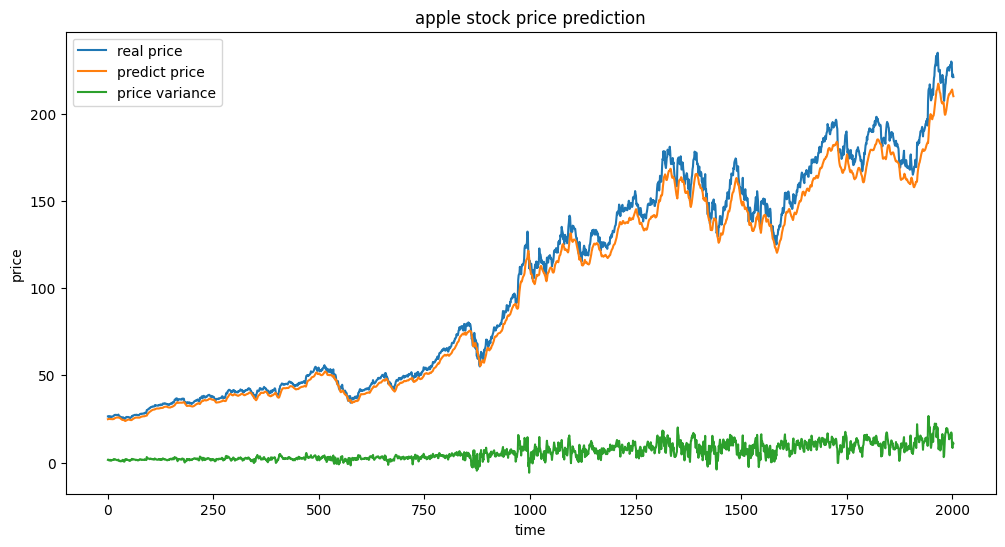

In [22]:
predicted_prices_scaled = model.predict(X_test)

predicted_prices = scaler.inverse_transform(predicted_prices_scaled)
actual_prices = scaler.inverse_transform(y_test)

price_difference = actual_prices.flatten() - predicted_prices.flatten()

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='real price')
plt.plot(predicted_prices, label='predict price')
plt.plot(price_difference, label='price variance')
plt.legend()
plt.title('apple stock price prediction')
plt.xlabel('time')
plt.ylabel('price')
plt.show()

# MAE & MASE

In [23]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

# 計算 MAE
mae = mean_absolute_error(actual_prices, predicted_prices)

# 計算 MASE
# 首先，我们需要一个naive预测来计算比例
# naive预测是前一天的价格
naive_forecast = actual_prices[:-1]
actual_values = actual_prices[1:]
mae_naive = mean_absolute_error(actual_values, naive_forecast)

mase = mae / mae_naive

print(f"MAE: {mae:.4f}")
print(f"MASE: {mase:.4f}")

MAE: 5.9826
MASE: 4.4076


# AIC
AIC 的計算需要模型的似然值和參數數量。由於我們使用的是神經網絡模型，直接計算似然值比較困難。因此，我們可以使用一個近似方法，基於模型的損失函數和參數數量來估計 AIC。

In [24]:
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

# 获取模型的损失函数
loss = model.evaluate(X_test, y_test, verbose=0)

# 获取模型的参数数量
num_params = np.sum([K.count_params(w) for w in model.trainable_weights])

# 计算 AIC
aic = 2 * num_params + 2 * loss

print(f"AIC: {aic:.4f}")

AIC: 46602.0020
